# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [0]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
import pandas as pd
from keras import Model
from keras.utils import Sequence
from keras.backend import epsilon
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [0]:
import os
os.chdir('/content/drive/My Drive/Advanced Computer Vision Project ')

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
data = np.load('/content/drive/My Drive/Advanced Computer Vision Project /images.npy', allow_pickle = True)

### Check one sample from the loaded "images.npy" file  (2 marks)

In [0]:
data

array([[array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8),
        list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615

In [0]:
data[1]

array([array([[[207, 216, 227, 255],
        [206, 216, 227, 255],
        [207, 216, 227, 255],
        ...,
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       [[207, 216, 227, 255],
        [207, 216, 227, 255],
        [207, 216, 227, 255],
        ...,
        [ 35,  32,  33, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       [[207, 216, 227, 255],
        [207, 216, 227, 255],
        [207, 215, 227, 255],
        ...,
        [ 35,  33,  33, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       ...,

       [[ 31,  21,  17, 255],
        [ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        ...,
        [  0,   1,   4, 255],
        [  0,   1,   4, 255],
        [  0,   1,   4, 255]],

       [[ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        ...,
        [  0,   1,   4, 255],
        [  0,   1,   4, 255],
        [  0,   1,   4, 255]],

     

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
arraysize = int(data.shape[0])

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((arraysize, IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((arraysize, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(arraysize):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [0]:
#### Add your code here ####
print("Shape of Images : ")
X_train.shape

Shape of Images : 


(409, 224, 224, 3)

In [0]:
#### Add your code here ####
print("Shape of masks : ")
masks.shape

Shape of masks : 


(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.59215689  0.68627453 -0.08235294]
  [ 0.49019611  0.57647061 -0.17647058]
  [ 0.51372552  0.60784316 -0.13725489]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.66274512  0.74117649 -0.01960784]
  [ 0.54509807  0.64705884 -0.13725489]
  [ 0.47450984  0.56862748 -0.23921567]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.7647059   0.82745099  0.05098045]
  [ 0.58431375  0.67058825 -0.17647058]
  [ 0.34901965  0.45098042 -0.48235291]]

 ...

 [[ 0.34901965  0.34901965  0.41960788]
  [ 0.52941179  0.52941179  0.60784316]
  [ 0.28627455  0.28627455  0.34901965]
  ...
  [ 0.14509809 -0.10588235 -0.09803921]
  [-0.69411767 -0.62352943 -0.4588235 ]
  [-0.89019608 -0.74117649 -0.46666664]]

 [

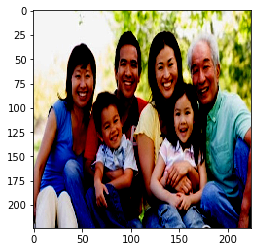

In [0]:
from matplotlib import pyplot
n = 4
print(X_train[n])
pyplot.imshow(X_train[n])

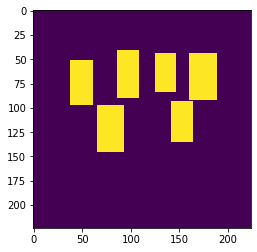

In [0]:
pyplot.imshow(masks[n])

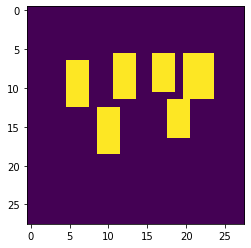

In [0]:
masks2 = np.zeros((arraysize, 28, 28))
for index in range(arraysize):
    masks2[index] = cv2.resize(masks[index], dsize=(28, 28), interpolation=cv2.INTER_NEAREST)
pyplot.imshow(masks2[n])

In [0]:
 base_model1 = MobileNet(weights='imagenet',  alpha = 1.0,  input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
 #base_model1.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 0s 0us/step


## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
def create_model(trainable=True):
    model = MobileNet(weights='imagenet', include_top=False, alpha = 1.0,  input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid", padding= 'valid')(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [0]:
model = create_model(False)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    dice = numerator / (denominator + tf.keras.backend.epsilon())
    return dice

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())
    

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [0]:
model.fit(  x = X_train, y = masks2,      
            epochs=100,
            callbacks=[checkpoint, reduce_lr, stop],
            batch_size = 1, 
            verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 409 samples
Epoch 1/100
405/409 [============================>.] - ETA: 0s - loss: 2.0461 - dice_coefficient: 0.2655
Epoch 00001: loss improved from inf to 2.03777, saving model to model-2.04.h5
409/409 [==============================] - 13s 31ms/sample - loss: 2.0378 - dice_coefficient: 0.2676
Epoch 2/100
406/409 [============================>.] - ETA: 0s - loss: 1.4437 - dice_coefficient: 0.3798
Epoch 00002: loss improved from 2.03777 to 1.44231, saving model to model-1.44.h5
409/409 [==============================] - 3s 7ms/sample - loss: 1.4423 - dice_coefficient: 0.3796
Epoch 3/100
401/409 [============================>.] - ETA: 0s - loss: 1.2808 - dice_coefficient: 0.4269
Epoch 00003: loss improved from 1.44231 to 1.28381, saving model to model-1.28.h5
409/409 [==============================] - 4s 10ms/sample - loss: 1.2838 - dice_coefficient: 0.4262
Epoch 4/100
401/409 [=======

### Get the predicted mask for a sample image   (3 marks)

In [0]:
sample_image = X_train[n]
#### Add your code here ####
sample_image.shape
input_data = sample_image.reshape((-1, IMAGE_WIDTH, IMAGE_HEIGHT, 3))
input_data.shape
ypred = model.predict(input_data)
ypred

array([[[0.00000000e+00, 2.98023224e-08, 1.26361847e-05, 1.15633011e-05,
         8.57114792e-05, 3.34709883e-04, 1.82092190e-04, 5.15282154e-05,
         1.10328197e-04, 5.35249710e-05, 3.46273184e-04, 6.08146191e-04,
         1.70648098e-04, 8.06152821e-05, 1.52084231e-03, 9.74446535e-04,
         1.34497881e-03, 5.49167395e-04, 1.01822615e-03, 3.20255756e-04,
         3.61502171e-04, 2.82764435e-03, 1.39346719e-03, 1.03294849e-03,
         1.10536814e-04, 3.77893448e-05, 1.68383121e-05, 2.14874744e-05],
        [0.00000000e+00, 2.68220901e-07, 4.04715538e-04, 3.68475914e-04,
         1.53571367e-03, 5.72267175e-03, 3.70296836e-03, 1.36449933e-03,
         1.04820728e-03, 2.04706192e-03, 2.64820457e-03, 3.92834842e-02,
         6.25315309e-03, 2.33501196e-03, 8.10599327e-03, 3.48863006e-03,
         6.05212450e-02, 4.42244411e-02, 1.13432109e-02, 1.03633404e-02,
         1.17796957e-02, 2.04109550e-02, 1.20821297e-02, 1.19240880e-02,
         5.24729490e-04, 7.30842352e-04, 4.3880939

In [0]:
ypred.shape

(1, 28, 28)

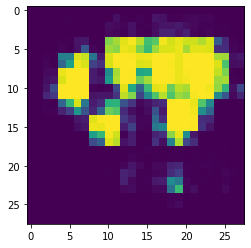

In [0]:
#ypred = np.expand_dims(ypred, axis=0)
pyplot.imshow(np.squeeze(ypred))

### Impose the mask on the image (3 marks)

In [0]:
predmask = cv2.resize(np.squeeze(ypred), dsize=(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)

In [0]:
predmask.shape

(224, 224)

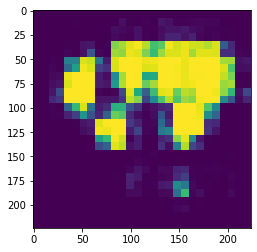

In [0]:
pyplot.imshow(predmask)

In [0]:
image2 = X_train[n]
print(image2.shape)
image2[:,:,0] = predmask*image2[:,:,0]
image2[:,:,1] = predmask*image2[:,:,1]
image2[:,:,2] = predmask*image2[:,:,2]

out_image = image2


(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


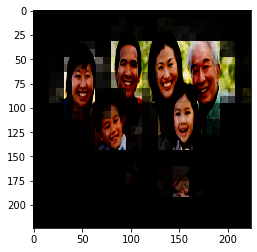

In [0]:
pyplot.imshow(out_image)